### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{2}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [5]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


#### New initial conditions - Gaussian Distribution

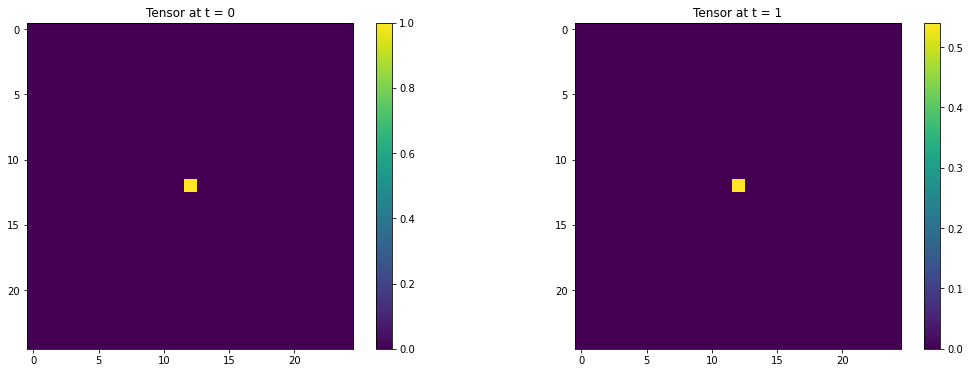

In [6]:
# Specify the size of the tensor
xysize = 25

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

#### C spead of sound

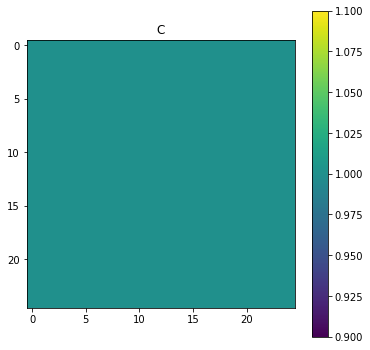

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [7]:
c_np = np.ones((xysize, xysize))

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2

c = torch.from_numpy(c_np).float().requires_grad_()

# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

c = c.to(device)
print(c)

#### Sigma2

In [8]:
l = xysize/10

In [9]:
value_origin_point = - 9 * (4-0)
k = 400

In [10]:
sigma2 = torch.zeros((xysize, xysize), dtype=torch.float32)

In [11]:
l_over_speed = (l / 1) * 0.05 
print(l_over_speed)

0.125


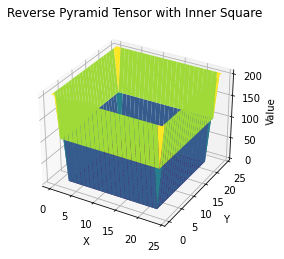

In [12]:
def create_reverse_pyramid_tensor(size, inner_square_ratio):
    pyramid = np.zeros((size, size), dtype=np.float32)

    center = size // 2
    center_value = -16.0/(l_over_speed*l_over_speed)
    boundary_value = 4.0/(l_over_speed*l_over_speed)

    inner_square_width = int(size * inner_square_ratio)

    for i in range(size):
        for j in range(size):
            distance_to_center = max(abs(i - center), abs(j - center))
            
            # Set the values for the reverse pyramid
            pyramid[i, j] = center_value + 4.0/(l_over_speed*l_over_speed) * (distance_to_center/xysize/0.1)
            
            # Set the values for the inner square to 0
            if (
                i >= center - inner_square_width // 2 and i < center + inner_square_width // 2
                and j >= center - inner_square_width // 2 and j < center + inner_square_width // 2
            ):
                pyramid[i, j] = 0.0

    return pyramid

# Set the size of the pyramid (choose an odd number for symmetry)
pyramid_size = 25  # xysize = 25
# inner_square_ratio = 9/10
inner_square_ratio = 4/5

# Create the reverse pyramid tensor with inner square values set to 0
sigma2 = create_reverse_pyramid_tensor(pyramid_size, inner_square_ratio)

# Plot the reverse pyramid tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, pyramid_size, 1)
y = np.arange(0, pyramid_size, 1)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, sigma2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('Reverse Pyramid Tensor with Inner Square')

plt.show()

sigma2 = torch.from_numpy(sigma2).to(device)

tensor([[204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000],
        [204.8000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

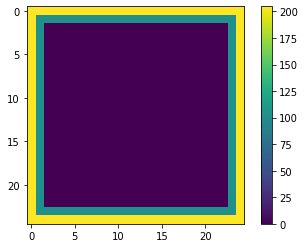

In [13]:
print(sigma2)
plt.imshow(sigma2.detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

#### ML

In [14]:
ML = torch.ones((1, 1, xysize, xysize), dtype=torch.float64)

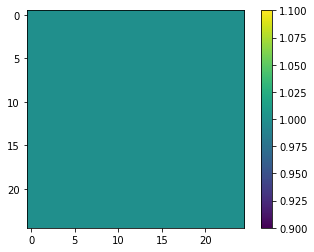

In [15]:
plt.imshow((ML/ML)[0][0].detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

### Define NN Model

#### one time step - skipping layers

In [16]:
# class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
#     def __init__(self, xysize, filter_weight):
#         super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

#         # Specify the size of the input (batch_size, channels, height, width)
#         in_channels = 1

#         # Specify the size of the filter/kernel
#         kernel_size = filter_weight.shape[2]
#         padding = (kernel_size - 1) // 2

#         # Create a Conv2d layer with the specified weight, input size, and padding
#         self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
#         self.conv_layer.weight.data = filter_weight

#         self.xysize = xysize

#     def forward(self, status_tn, status_tn_1, c_value, sigma2_inv):
#         output_list = [status_tn]

#         c = torch.ones((self.xysize, self.xysize), device=device)
        
#         for i in range(c_value.shape[0]):
#             for j in range(c_value.shape[0]):
#                 ones = torch.zeros((self.xysize, self.xysize), device=device)
#                 ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0]), j*int(self.xysize/c_value.shape[0]):(j+1)*int(self.xysize/c_value.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#                 c += ones * c_value[i]

#         # Calculate status_tn1 based on the provided expression
#         c_status_tn = c * status_tn
#         conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
#         status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
#         output_list.append(status_tn1)

#         output_stacked = torch.cat(output_list, dim=1)

#         return output_stacked

In [16]:
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
        output_list = [status_tn]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers 10 C values

In [17]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [18]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

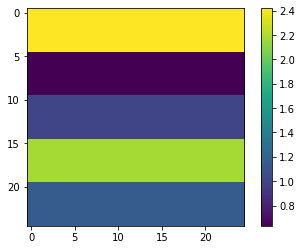

In [19]:
a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
    ones[i*5:(i+1)*5] = 1
    c += ones * vec[i]


plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

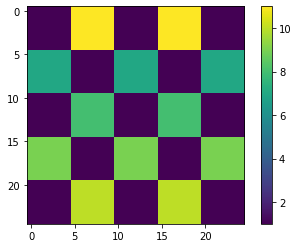

In [20]:
a = 0.5  # lower bound
b = 3  # upper bound
# vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)
vec = [10, 6, 7, 8, 9]

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = (i+j) % 2  # Alternate between 0 and 1
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

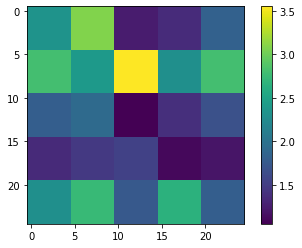

In [21]:
torch.manual_seed(0)  # Set the seed

a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = torch.rand(1).item()  # Assign a random value
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

### Define functions to form C values

In [32]:
def create_simple_checkerboard(c_values_tensor):
    c = torch.ones((xysize, xysize), device=device)
        
    for i in range(c_values_tensor.shape[0]):
        for j in range(c_values_tensor.shape[0]):
            ones = torch.zeros((xysize, xysize), device=device)
            ones[i*int(xysize/c_values_tensor.shape[0]):(i+1)*int(xysize/c_values_tensor.shape[0]), j*int(xysize/c_values_tensor.shape[0]):(j+1)*int(xysize/c_values_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
            c += ones * c_values_tensor[i]
    
    return c

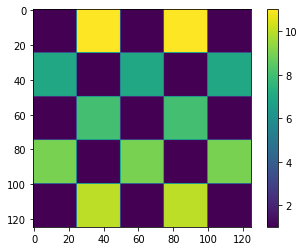

In [33]:
C_tensors_list = [10, 6, 7, 8, 9]
c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)
c = create_simple_checkerboard(c_tensor)
plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

tensor([5., 7., 5., 5., 6., 1., 9., 3., 3., 4., 6., 2., 5., 6., 9., 7., 5., 6.,
        6., 5., 4., 7., 9., 2., 9.], device='cuda:0', requires_grad=True)


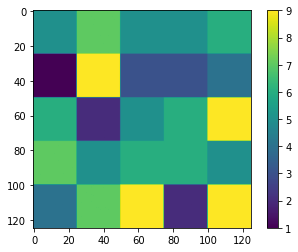

In [42]:
# number_rows = 5
# number_cols = 5
# number_all = number_rows * number_cols

# torch.manual_seed(0)  # Set the seed for reproducibility

# # c_values_tensor = torch.rand(number_all, dtype=torch.float32, device=device, requires_grad=True)
# c_values_tensor = torch.randint(low=0, high=10, size=(number_all,), device=device, dtype=torch.int)
# print(c_values_tensor)

# c = torch.zeros((xysize, xysize), device=device)  # Initialize c with zeros

# for i in range(number_rows):
#     for j in range(number_cols):
#         ones = torch.zeros((xysize, xysize), device=device)
#         ones[i*int(xysize/number_rows):(i+1)*int(xysize/number_rows), j*int(xysize/number_cols):(j+1)*int(xysize/number_cols)] = c_values_tensor[i*number_rows + j]
#         c += ones


number_rows = 5
number_cols = 5
number_all = number_rows * number_cols
torch.manual_seed(0)
c_values_tensor = torch.randint(low=1, high=10, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)

print(c_values_tensor)

def create_checkerboard(c_values_tensor, xsize, ysize, number_rows, number_cols):
    

    c = torch.zeros((xsize, ysize), device=device)  # Initialize c with zeros

    for i in range(number_rows):
        for j in range(number_cols):
            ones = torch.zeros((xsize, ysize), device=device)
            ones[i*int(xsize/number_rows):(i+1)*int(xsize/number_rows), j*int(ysize/number_cols):(j+1)*int(ysize/number_cols)] = c_values_tensor[i*number_rows + j]
            c += ones

    return c

c = create_checkerboard(c_values_tensor, xysize, xysize, number_rows, number_cols)

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()



### Data assimilation one timestep - skipping layers

#### Generate Obs

In [22]:
# # Specify the size of the tensor
# xysize = 125
# mu_x = 0.2   # 0.5
# mu_y = 0.2  # 0.5

# timesteps = 10    # 300

# # C values
# C_values_list = [5, 6, 7, 8, 9]
# # C_values_list = [1, 1, 1, 1, 1]
# c_tensor = torch.tensor(C_values_list, dtype=torch.float32, device=device, requires_grad=True)

# nlayers = c_tensor.size(0)

# # Plot C
# c = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)

# for i in range(nlayers):
#     ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
#     ones[i*int(xysize/nlayers):(i+1)*int(xysize/nlayers)] = 1
#     c += ones * c_tensor[i]

# plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Ground Truth')
# plt.show()

# # Create a meshgrid
# x_values = np.linspace(0, 1, xysize)
# y_values = np.linspace(0, 1, xysize)
# x, y = np.meshgrid(x_values, y_values)

# # Convert NumPy arrays to PyTorch tensors with float type
# x_tensor = torch.tensor(x, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.float32)

# # Equation parameters
# sqrt2 = np.sqrt(2)
# pi = np.pi

# # Define the time tensors for t = 0, 1, and 2
# time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
# time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# # Function to create 2D Gaussian distribution
# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
#     exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
#     return torch.exp(exponent)

# # Parameters for Gaussian distributions
# sigma_x = 0.005
# sigma_y = 0.005

# # Evaluate the Gaussian distributions at t = 0, 1, and 2
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# # Stack the tensors along a new dimension to create 3D tensors
# status_t0 = t0_values
# status_t1 = t1_values

# filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# mymodel_multi = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

# status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# # Perform a forward pass using AI4WaveNeuralNetwork
# status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# # Initial Status (t = 0)
# fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# # Plot the image on the first subplot
# im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
# fig.colorbar(im, ax=axs[0])
# axs[0].set_title("Initial Status (t = 0)")

# # Plot the vertical profile on the second subplot
# vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
# axs[1].plot(vertical_profile)
# axs[1].set_title("Vertical profile at t = 0")

# plt.show()

# # Initial Status (t = 1)
# fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# # Plot the image on the first subplot
# im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
# fig.colorbar(im, ax=axs[0])
# axs[0].set_title("Initial Status (t = 1)")

# # Plot the vertical profile on the second subplot
# vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
# axs[1].plot(vertical_profile)
# axs[1].set_title("Vertical profile at t = 1")

# plt.show()

# output_tensor_obs = mymodel_multi(status_t1_tensor, status_t0_tensor, c_tensor, sigma2, nsteps = timesteps)

# for i in range(timesteps):
#     if (i) % 5 == 0:
#         fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

#         # Plot the image on the first subplot
#         im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[0][i+2], cmap='viridis')
#         fig.colorbar(im, ax=axs[0])
#         axs[0].set_title(f"Status at t = {i+2}")

#         # Plot the vertical profile on the second subplot
#         vertical_profile = output_tensor_obs.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
#         axs[1].plot(vertical_profile)
#         axs[1].set_title(f"Vertical profile at t = {i+2}")

#         plt.show()

# print(output_tensor_obs.shape)

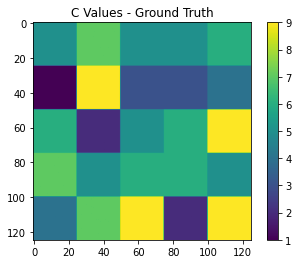

torch.Size([502, 125, 125])


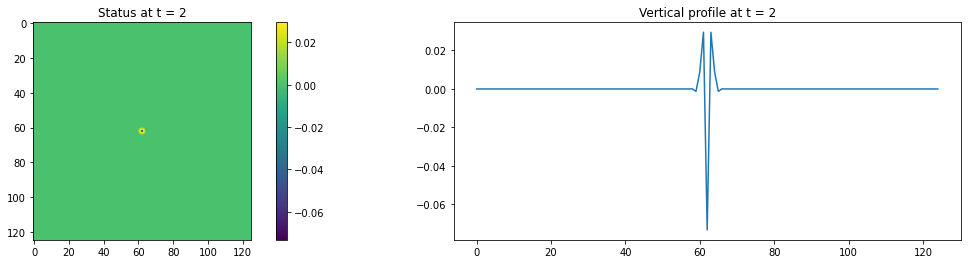

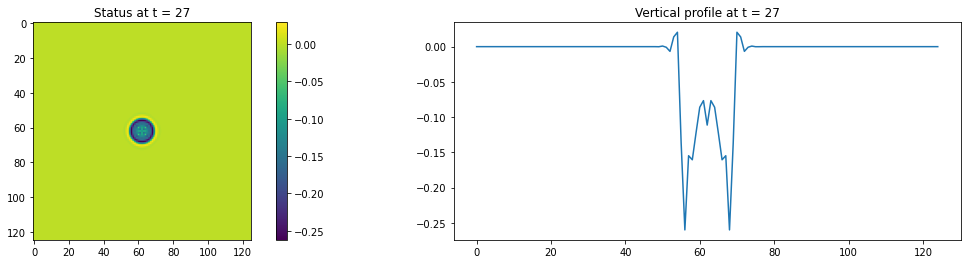

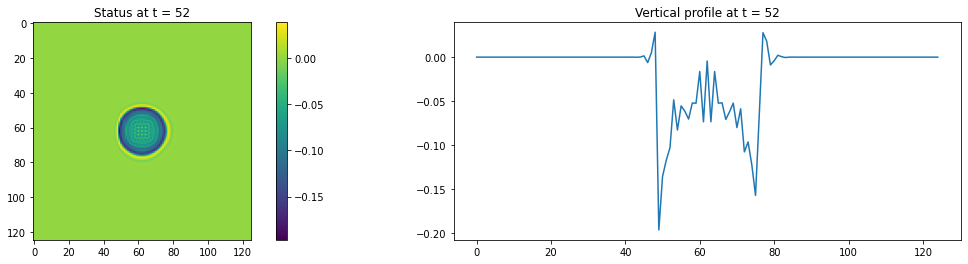

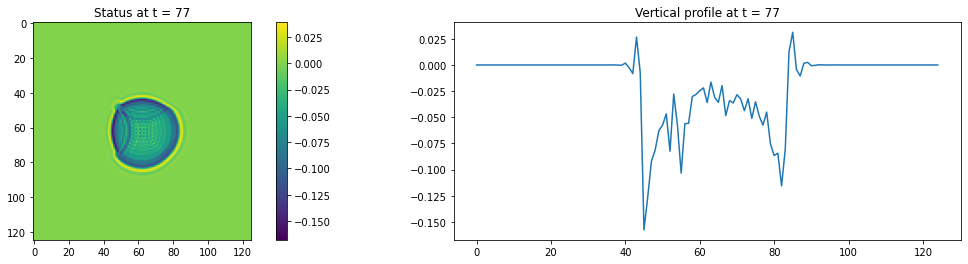

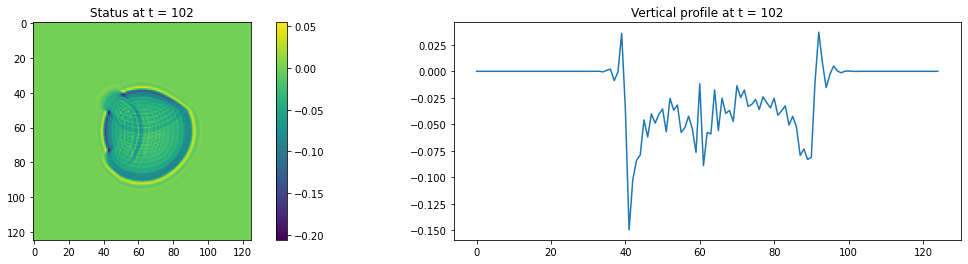

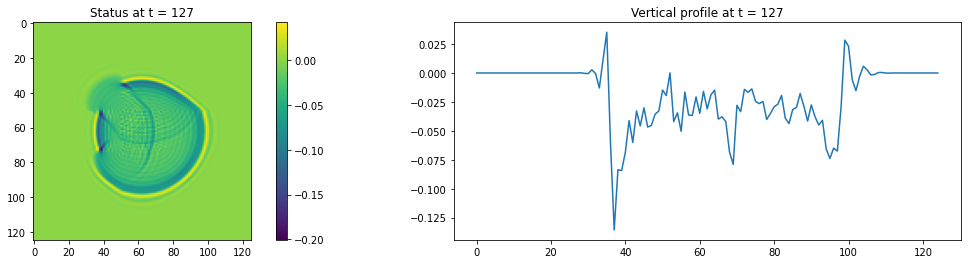

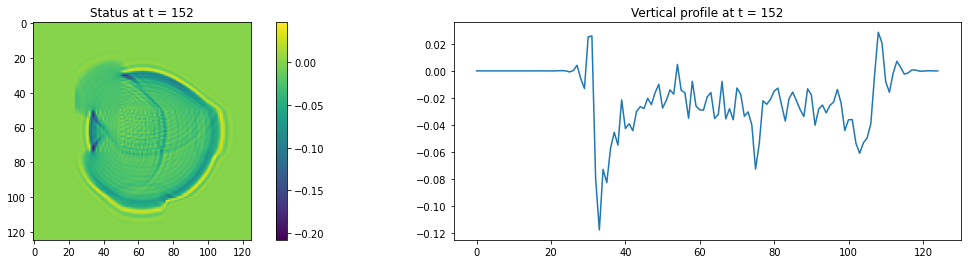

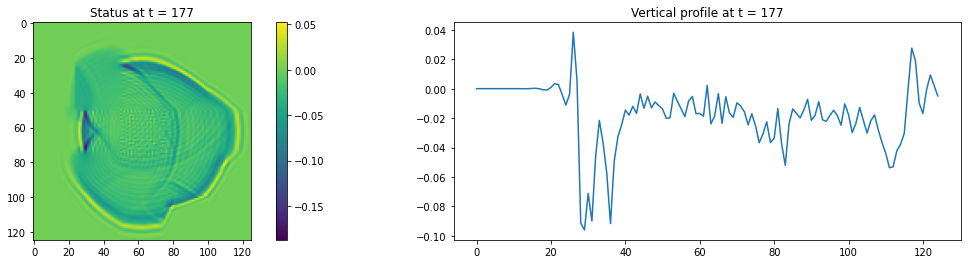

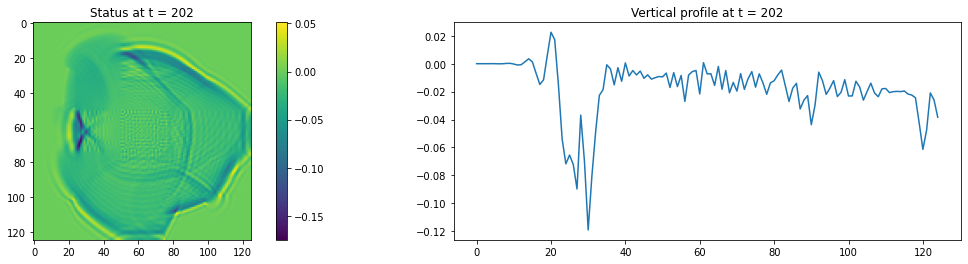

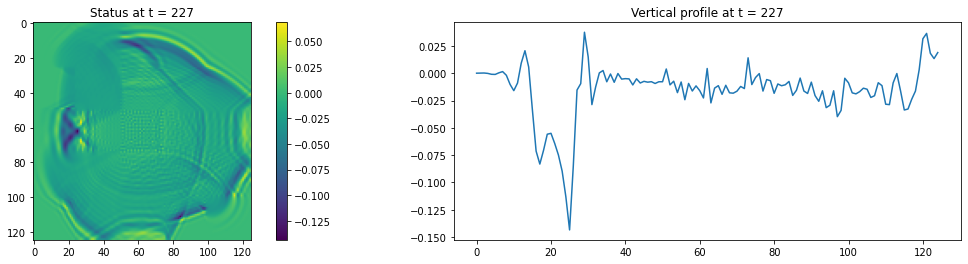

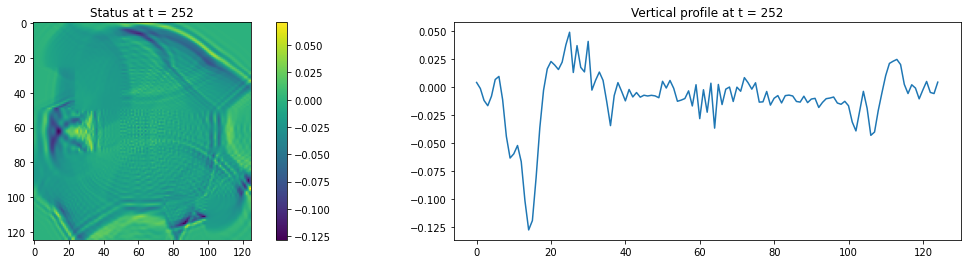

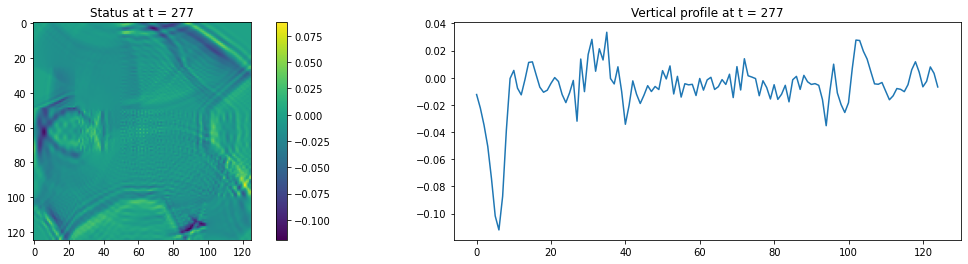

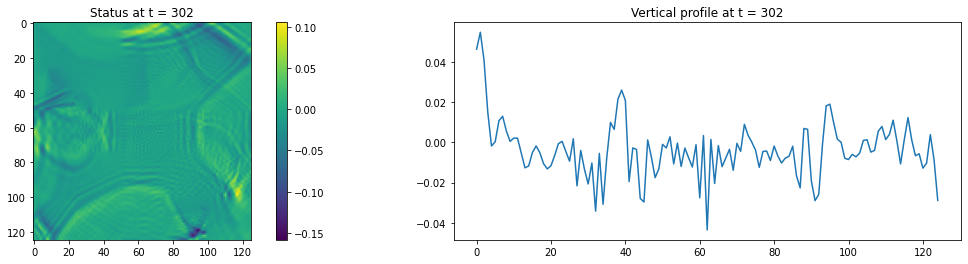

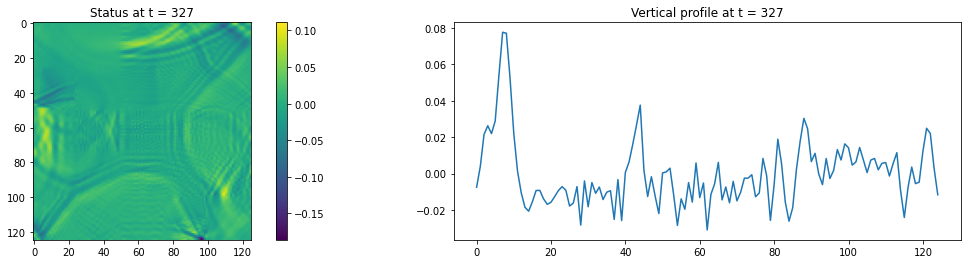

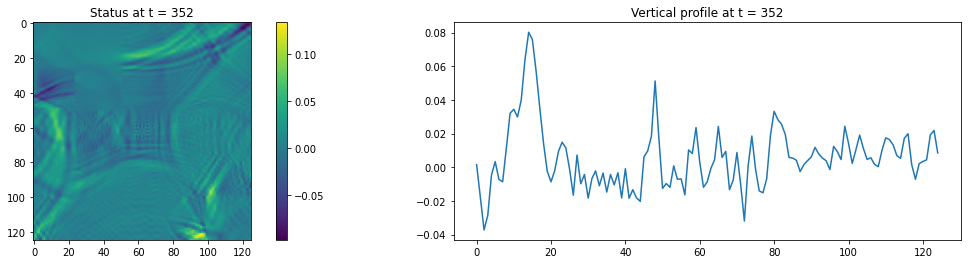

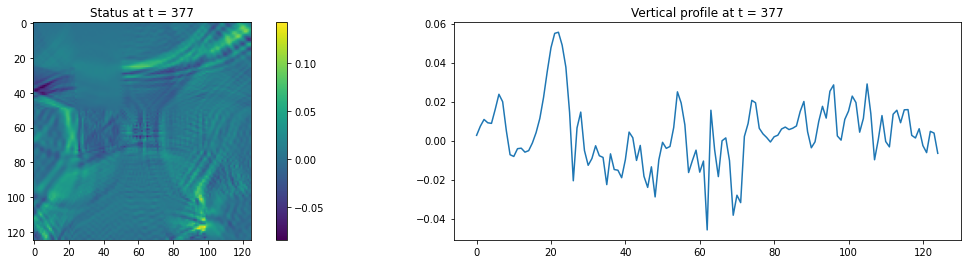

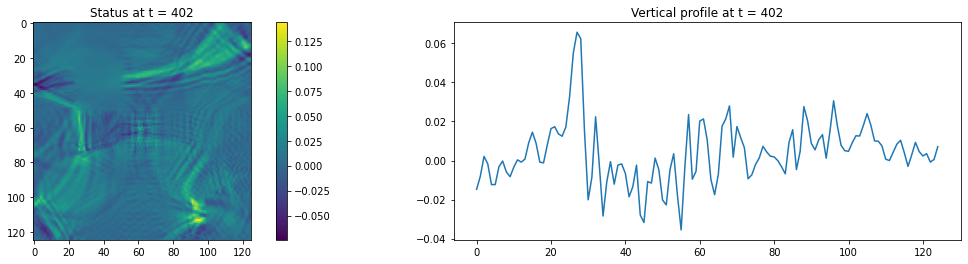

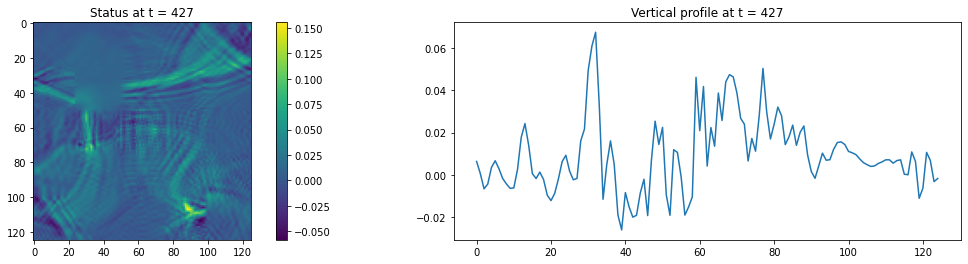

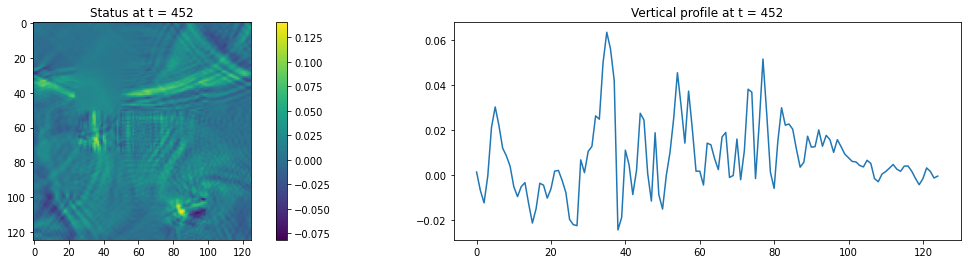

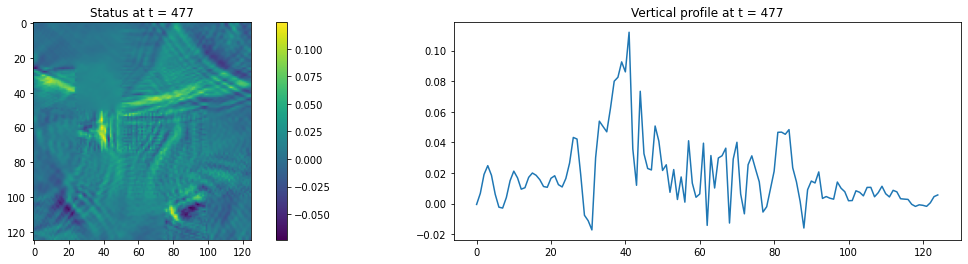

torch.Size([502, 125, 125])


In [43]:
timesteps = 500

# Specify the size of the tensor
xysize = 125
mu_x = 0.5   # 0.5
mu_y = 0.5  # 0.5

# # C values
# C_tensors_list = [10, 6, 7, 8, 9]
# # C_tensors_list = [1, 1, 1, 1, 1]
# c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)

# nlayers = c_tensor.size(0)

# # Plot C
# c = torch.ones((xysize, xysize), device=device, dtype=torch.float32)

# for i in range(nlayers):
#     for j in range(nlayers):
#         ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
#         ones[i*int(xysize/c_tensor.shape[0]):(i+1)*int(xysize/c_tensor.shape[0]), j*int(xysize/c_tensor.shape[0]):(j+1)*int(xysize/c_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#         c += ones * c_tensor[i]  # Use both i and j to index c_tensor

# plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Ground Truth')
# plt.show()

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# Define a single model
mymodel_obs = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight).to(device)


# Forward pass through the model
output_list = [status_t0_tensor, status_t1_tensor]
input1 = status_t1_tensor
input2 = status_t0_tensor


number_rows = 5
number_cols = 5
number_all = number_rows * number_cols
torch.manual_seed(0)
c_values_tensor_obs = torch.randint(low=1, high=10, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)
c = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)

c_show = c
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

for _ in range(timesteps):
    output = mymodel_obs(input1, input2, c, sigma2)
    output_list.append(output[:,1:, :, :])
    input1 = output[:,1:, :, :]
    input2 = output[:,0:1, :, :]

# Concatenate the output list along the time dimension
output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)

print(output_tensor_obs.shape)

for i in range(timesteps):
    if (i) % 25 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_obs.cpu().detach().numpy()[i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_obs.shape)

In [44]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([502, 125, 125])


#### One time forward stepping

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [124 122]
 [124 123]
 [124 124]]


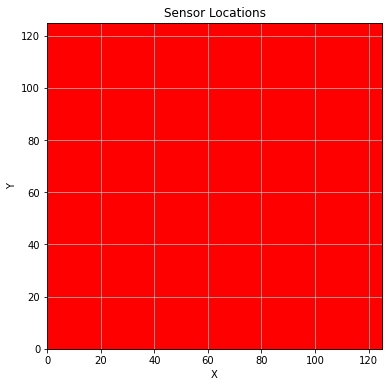

In [55]:
# Set the seed for reproducibility
np.random.seed(0)

# Define the size of your domain
domain_size = (xysize, xysize)  # Example: xysizexxysize grid

n_srata = 125    #  5
n_sensors = n_srata * n_srata

# Define the number of strata in each dimension
strata_size = (n_srata, n_srata)  # Example: 10x10 strata

# Calculate the size of each stratum
stratum_size = (domain_size[0] // strata_size[0], domain_size[1] // strata_size[1])

# Generate random sensor locations within each stratum
sensor_indices = np.array([
    (np.random.randint(i * stratum_size[0], (i + 1) * stratum_size[0]),
     np.random.randint(j * stratum_size[1], (j + 1) * stratum_size[1]))
    for i in range(strata_size[0])
    for j in range(strata_size[1])
])

# Plot the domain
plt.figure(figsize=(6, 6))
plt.xlim(0, domain_size[0])
plt.ylim(0, domain_size[1])

print(sensor_indices)

# Plot the sensor locations
plt.scatter(sensor_indices[:, 0], sensor_indices[:, 1], color='red')

plt.title('Sensor Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [56]:
# Convert sensor_indices to a PyTorch tensor
sensor_indices = torch.tensor(sensor_indices)

# Separate the x and y coordinates
x_coords = sensor_indices[:, 0]
y_coords = sensor_indices[:, 1]

# Use broadcasting to create a grid of indices
x_coords = x_coords[None, :, None]
y_coords = y_coords[None, :, None]

# Index the output and observation tensors at the sensor locations
# output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
# obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

# Now, output_at_sensors and obs_at_sensors should have the shape (302, 25)
# print(output_at_sensors.shape)
# print(obs_at_sensors.shape)

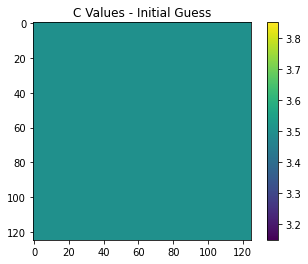

c_value_1,▂▄▆▇██▇▆▄▃▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
c_value_10,▁▃▇█▇▄▂▁▁▂▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
c_value_11,▁▂▁▁▃▅▇██▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
c_value_12,██▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
c_value_13,▁▃▆██▆▇▆▆▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
c_value_14,▁▂▅▇▇▆▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
c_value_15,▁▁▂▃▄▅▅▆▇███████████████████████████████
c_value_16,▁▂▃▄▅▅▆████▇████████████████████████████
c_value_17,▁▃▆██▆▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
c_value_18,▁▂▄▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
c_value_19,▁▂▄▇▇▆▇██▇▇█████████████████████████████


2024-04-03 14:56:15.174027: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


epochs: 0
epochs: 100
epochs: 200


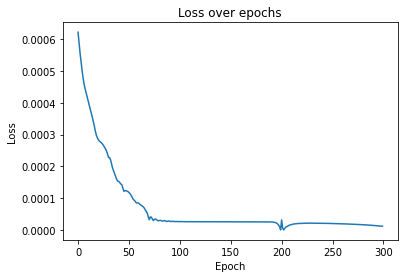

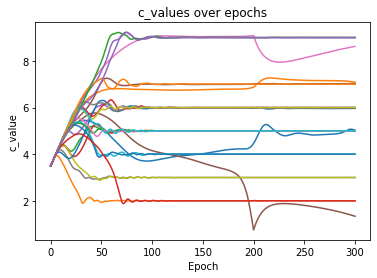

In [57]:
mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# Start a new run
run = wandb.init(project="wave eqn - checkerboard", name = "form c outside model obs {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_values_list, C_guess_value, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []
epochs = 300

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    # c = torch.ones((xysize, xysize), device=device)
        
    # for i in range(c_forward1.shape[0]):
    #     for j in range(c_forward1.shape[0]):
    #         ones = torch.zeros((xysize, xysize), device=device)
    #         ones[i*int(xysize/c_forward1.shape[0]):(i+1)*int(xysize/c_forward1.shape[0]), j*int(xysize/c_forward1.shape[0]):(j+1)*int(xysize/c_forward1.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
    #         c += ones * c_forward1[i]

    c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)

    

    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()

tensor([5., 7., 5., 5., 6., 1., 9., 3., 3., 4., 6., 2., 5., 6., 9., 7., 5., 6.,
        6., 5., 4., 7., 9., 2., 9.], device='cuda:0', requires_grad=True)


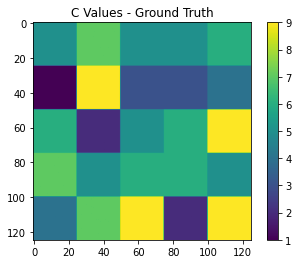

In [58]:
print(c_values_tensor_obs)

c_show = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

[5.025864601135254, 7.080934047698975, 5.0012946128845215, 5.0021867752075195, 6.000890731811523, 1.337380051612854, 8.622984886169434, 2.999821901321411, 2.999436140060425, 3.9995322227478027, 5.9628682136535645, 1.9982783794403076, 5.000805854797363, 5.998915672302246, 9.000808715820312, 7.025362491607666, 4.99251651763916, 5.9968953132629395, 5.999954700469971, 4.999925136566162, 4.001614570617676, 7.00230073928833, 9.004517555236816, 2.0000720024108887, 9.00023078918457]


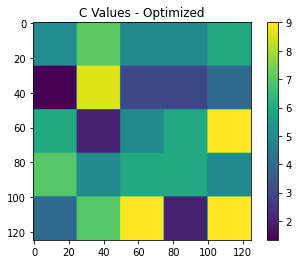

In [59]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimized')
plt.show()

#### Visualise computational graph

In [32]:
mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

# lr = 0.1
lr = 0.1

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(1):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor
    for _ in range(timesteps):
        output = model(input1, input2, c_forward1, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    print(loss.item())

epochs: 0
1.0926937523206282e-12


In [33]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values': c_forward1})

dot.render(filename='graph_smallmodel', format='pdf')

'graph_smallmodel.pdf'